In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from src.encoders_decoders import *
from src.losses import *
import random

In [3]:
def distortion_gaussian(x,encoder,decoder,lat_samp=10,tau=0.5):
    #Logit r|x
    l_r_x = encoder(x)
    bsize,N = l_r_x.shape
    eps = torch.rand(bsize,lat_samp,N)
    r = torch.sigmoid((torch.log(eps) - torch.log(1-eps) + l_r_x[:,None,:])/tau)
    mu_dec,sigma2_dec = decoder(r)
    inv_sigma2_dec = 1/sigma2_dec
    mp = mu_dec*inv_sigma2_dec
    logq_x_r = -0.5*(x**2)*inv_sigma2_dec + x*mp - 0.5*mu_dec*mp - 0.5*torch.log(2*np.pi*sigma2_dec)
    D = -logq_x_r.mean()
    return D
def distortion_ideal(x,encoder,lat_samp=10,tau=0.5):
    l_r_x = encoder(x)
    bsize,N = l_r_x.shape
    eps = torch.rand(bsize,lat_samp,N)
    r = torch.sigmoid((torch.log(eps) - torch.log(1-eps) + l_r_x[:,None,:])/tau)
    lam = encoder(x).transpose(0,1)
    b = -torch.log(torch.exp(encoder(x))+1).transpose(0,1).sum(dim=0)[None,None,:]
    h = torch.softmax(r@lam + b,dim=2)
    D = torch.cat([-torch.log(h[i,:,i]) for i in range(bsize)]).mean()
    return D
def rate_iidBernoulli(x,encoder,p_q):
    l_r_x = encoder(x)
    R = (torch.sigmoid(l_r_x)*(F.logsigmoid(l_r_x) - np.log(p_q)) + torch.sigmoid(-l_r_x)*(F.logsigmoid(-l_r_x) - np.log(1-p_q))).sum(dim=1).mean()
    return R
def rate_vampBernoulli(x,encoder,x_k):
    #x_k = x_sorted[random.sample(range(500),K)]
    l_r_x = encoder(x_sorted)[:,:,None]
    l_r = encoder(x_k).transpose(0,1)[None,:,:]
    KLs = (torch.sigmoid(l_r_x)*(F.logsigmoid(l_r_x) - F.logsigmoid(l_r)) + torch.sigmoid(-l_r_x)*  (F.logsigmoid(-l_r_x) - F.logsigmoid(-l_r))).sum(dim=1)
    R = -torch.logsumexp(-KLs-np.log(K),dim=1).mean()
    return R



In [22]:
DVec = []
DtVec = []
RVec = []

for sigmai in np.arange(0.01,0.2,0.01):
    enc = BernoulliEncoder(N,x_min-0.2,x_max+0.2)
    enc.log_sigmas = torch.nn.Parameter(torch.log(sigmai*torch.ones(N)[None,:]))
    inv_sigma2 = torch.exp(-2*enc.log_sigmas).transpose(0,1)
    phi0 = torch.cat((enc.cs.transpose(0,1)*inv_sigma2,-0.5*inv_sigma2),dim=1)
    dec = GaussianDecoder(phi0)
    DVec.append(distortion_gaussian(x_sorted,enc,dec,tau=0.1).item())
    DtVec.append(distortion_ideal(x_sorted,enc,tau=0.1).item())
    l_r_x = enc(x_sorted)
    #Dkl between two bernoulli distributions
    x_k = x_sorted[random.sample(range(500),K)]
    R =rate_vampBernoulli(x_sorted,enc,x_k)
    #print(R)
    RVec.append(R.item())
    


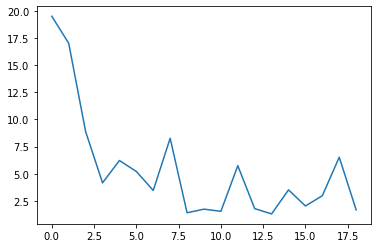

In [23]:
plt.plot(np.array(RVec)+np.array(DVec))
#plt.plot(DVec + np.log(500))

In [4]:
N = 50
K=5
#Define data distribution
x_data = torch.distributions.exponential.Exponential(0.5).sample((500,))[:,None]
x_sorted,indices = x_data.sort(dim=0)
x_min,x_max = x_sorted[0,:].item(),x_sorted[-1,:].item() 

In [5]:
N_EPOCHS =5000
lossVec = []
mseVec = []
enc = BernoulliEncoder(N,x_min-0.2,x_max+0.2)
inv_sigma2 = torch.exp(-2*enc.log_sigmas).transpose(0,1)
phi0 = torch.cat((enc.cs.transpose(0,1)*inv_sigma2,-0.5*inv_sigma2),dim=1)
dec = GaussianDecoder(phi0)
params = list(enc.parameters()) + list(dec.parameters())
optimizer = torch.optim.Adam(params,0.01)
for epoch in range(N_EPOCHS):
    loss = distortion_gaussian(x_data,enc,dec)
    lossVec.append(loss.item())
    #print(torch.softmax(decoder.qs,dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

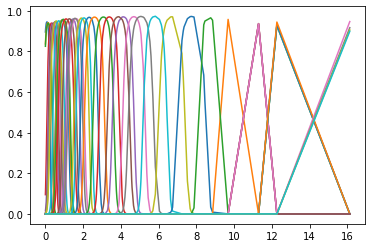

In [21]:
x_fine = np.arange
plt.plot(x_sorted,torch.sigmoid(enc(x_sorted)).detach())

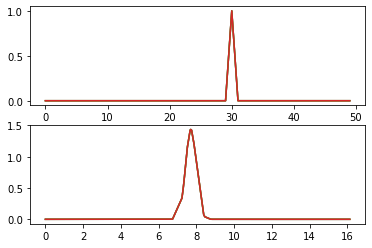

In [26]:
r = enc.sample(x_sorted,10)
mu_dec,sigma2_dec = dec(r)
with torch.no_grad():
    nsample =[1,3,5,7]
    fig,(ax1,ax2) = plt.subplots(2)
    q_x_r = torch.exp(torch.distributions.normal.Normal(mu_dec[490,nsample],torch.sqrt(sigma2_dec[490,nsample])).log_prob(x_sorted))
    ax1.plot(range(N),r[490,nsample,:].transpose(0,1))
    ax2.plot(x_sorted,q_x_r)
    #plt.show()
    

In [27]:
enc.cs

Parameter containing:
tensor([[ 0.0858,  0.1421,  0.1497,  0.3230,  0.3889,  0.4396,  0.5007,  0.5301,
          0.5815,  0.7100,  0.8832,  0.9171,  0.9528,  1.0990,  1.4490,  1.2729,
          1.6263,  1.5673,  1.9112,  2.0461,  2.3266,  2.6006,  3.0740,  3.3822,
          4.1234,  3.8741,  4.6861,  5.0657,  6.6976,  5.8141,  7.7486,  9.6785,
          8.6627, 11.2902, 11.2902, 11.2902, 11.2902, 12.2611, 12.2611, 12.2611,
         12.2611, 12.2611, 14.0188, 14.0238, 14.2923, 14.5167, 16.1221, 16.1221,
         16.1221, 16.1221]], requires_grad=True)

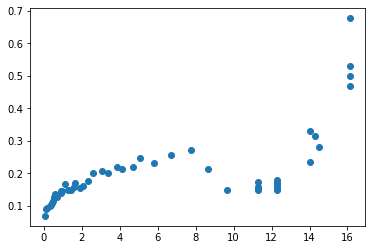

In [30]:
plt.scatter(enc.cs.detach(),torch.exp(enc.log_sigmas).detach())